In [98]:
import pandas as pd
import numpy as np

# Text processing and analysis
from nltk.corpus import stopwords
import re
import string

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# PyTorch for Neural Networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [17]:
# Dropping columns which have more than 90% missing values

missing_values = df.isnull().mean()
columns_to_drop = missing_values[missing_values > 0.9].index
df.drop(columns_to_drop, axis=1, inplace=True)
df.head()


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


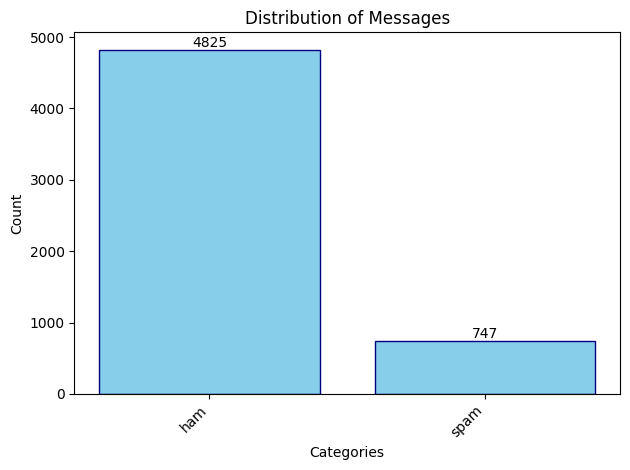

In [32]:
# Text messages - value_counts

v1_distribution = df["v1"].value_counts()
bars = plt.bar(v1_distribution.index, v1_distribution.values,
               align='center', color='skyblue', edgecolor='navy')
plt.title('Distribution of Messages')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')
plt.tight_layout()
plt.show()

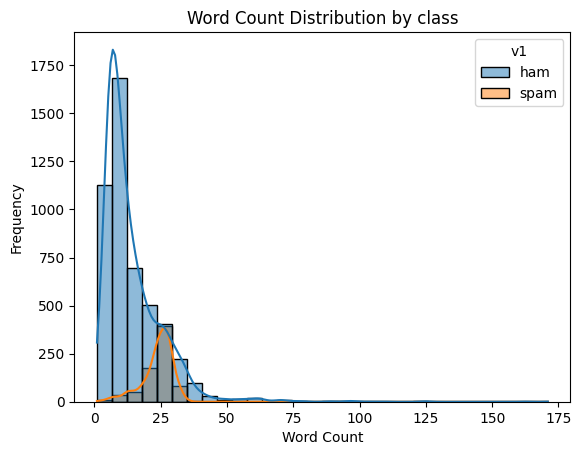

In [40]:
df["word_count"] = df["v2"].apply(lambda x: len(x.split()))
sns.histplot(data=df, x="word_count", hue="v1", bins=30, kde=True)
plt.title("Word Count Distribution by class")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

From this chart we get a clear insight that spam messages tend to be much longer

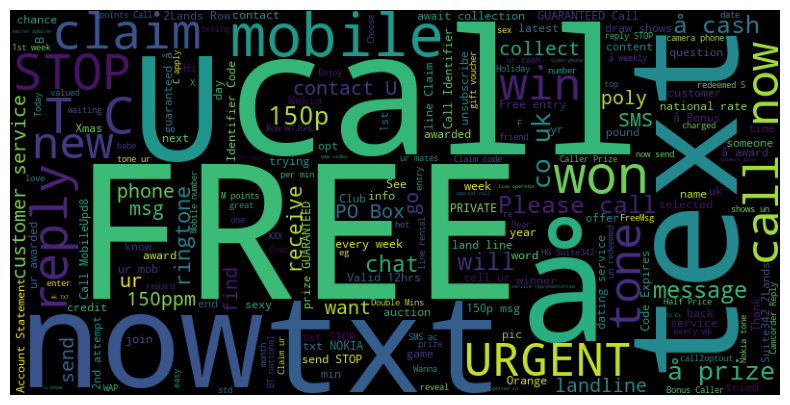

In [63]:
# Looking through most common words in spam messages
spam_texts = " ".join(df[df["v1"] == "spam"]["v2"])

# WordCloud will automatically count word frequencies
spam_wordcloud = WordCloud(width=800, height=400).generate(spam_texts)
plt.figure(figsize=(10,5))
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.show()

In [78]:
chat_words = {
"AFAIK": "As Far As I Know",
"AFK": "Away From Keyboard",
"ASAP": "As Soon As Possible",
"ATK": "At The Keyboard",
"ATM": "At The Moment",
"A3": "Anytime, Anywhere, Anyplace",
"BAK": "Back At Keyboard",
"BBL": "Be Back Later",
"BBS": "Be Back Soon",
"BFN": "Bye For Now",
"B4N": "Bye For Now",
"BRB": "Be Right Back",
"BRT": "Be Right There",
"BTW": "By The Way",
"B4": "Before",
"B4N": "Bye For Now",
"CU": "See You",
"CUL8R": "See You Later",
"CYA": "See You",
"FAQ": "Frequently Asked Questions",
"FC": "Fingers Crossed",
"FWIW": "For What It's Worth",
"FYI": "For Your Information",
"GAL": "Get A Life",
"GG": "Good Game",
"GN": "Good Night",
"GMTA": "Great Minds Think Alike",
"GR8": "Great!",
"G9": "Genius",
"IC": "I See",
"ICQ": "I Seek you (also a chat program)",
"ILU": "ILU: I Love You",
"IMHO": "In My Honest/Humble Opinion",
"IMO": "In My Opinion",
"IOW": "In Other Words",
"IRL": "In Real Life",
"KISS": "Keep It Simple, Stupid",
"LDR": "Long Distance Relationship",
"LMAO": "Laugh My A.. Off",
"LOL": "Laughing Out Loud",
"LTNS": "Long Time No See",
"L8R": "Later",
"MTE": "My Thoughts Exactly",
"M8": "Mate",
"NRN": "No Reply Necessary",
"OIC": "Oh I See",
"PITA": "Pain In The A..",
"PRT": "Party",
"PRW": "Parents Are Watching",
"QPSA?": "Que Pasa?",
"ROFL": "Rolling On The Floor Laughing",
"ROFLOL": "Rolling On The Floor Laughing Out Loud",
"ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
"SK8": "Skate",
"STATS": "Your sex and age",
"ASL": "Age, Sex, Location",
"THX": "Thank You",
"TTFN": "Ta-Ta For Now!",
"TTYL": "Talk To You Later",
"U": "You",
"U2": "You Too",
"U4E": "Yours For Ever",
"WB": "Welcome Back",
"WTF": "What The F...",
"WTG": "Way To Go!",
"WUF": "Where Are You From?",
"W8": "Wait...",
"7K": "Sick:-D Laugher",
"TFW": "That feeling when",
"MFW": "My face when",
"MRW": "My reaction when",
"IFYP": "I feel your pain",
"TNTL": "Trying not to laugh",
"JK": "Just kidding",
"IDC": "I don't care",
"ILY": "I love you",
"IMU": "I miss you",
"ADIH": "Another day in hell",
"ZZZ": "Sleeping, bored, tired",
"WYWH": "Wish you were here",
"TIME": "Tears in my eyes",
"BAE": "Before anyone else",
"FIMH": "Forever in my heart",
"BSAAW": "Big smile and a wink",
"BWL": "Bursting with laughter",
"BFF": "Best friends forever",
"CSL": "Can't stop laughing"
}


In [83]:
import emoji

def has_emoji(text):
    return emoji.is_emoji(text) or bool(emoji.emoji_list(text))

def has_emoji_regex(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

def has_link(text):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return bool(url_pattern.search(text))

def has_abbreviation(text):
    abbr_list = list(chat_words.keys())
    return any(abbr in text.upper() for abbr in abbr_list)

def has_tags(text):
    tag_pattern = re.compile('<[^>]+>')
    return bool(tag_pattern.search(text))

def text_check(text):
    if not isinstance(text, str):
        return {
            'emoji_regex': False,
            'emoji': False,
            'link': False,
            'abbreviation': False,
            'tags': False
        }
    checks = {
        'emoji_regex': has_emoji_regex(text),
        'emoji': has_emoji(text),
        'link': has_link(text),
        'abbreviation': has_abbreviation(text),
        'tags': has_tags(text)
    }
    return checks

In [84]:
df["text_checks"] = df["v2"].apply(text_check)
counter = {}

def get_count(text):
    for key, values in text.items():
        if values:
            counter[key] = counter.get(key, 0) + 1

df["text_checks"].apply(get_count)
counter

{'abbreviation': 4671, 'link': 19, 'tags': 6, 'emoji': 1}

In [91]:
# Pre-processing text

# removing abbreviation
def apply_abbreviation(text):
    abbr_list = list(chat_words.keys())
    new_words = []

    for word in text.split():
        if word.upper() in abbr_list:
            new_words.append(chat_words[word.upper()])
        else:
            new_words.append(word)

    return " ".join(new_words)

# removing emoji
def remove_emoji(text):
    return emoji.replace_emoji(text, '')

# removing emoji regex
def remove_emoji_regex(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub("", text)

# removing links
def remove_links(text):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub("", text)

# removing tags
def remove_tags(text):
    tag_pattern = re.compile('<[^>]+>')
    return tag_pattern.sub("", text)

# removing punctuation
def remove_punctuation(text):
    punctuation = string.punctuation
    for word in text.split():
        if word in punctuation:
            text = text.replace(word, "")
    return text

# remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    return " ".join([word for word in text.split() if word not in stop_words])

In [99]:
df["v2"] = df["v2"].str.lower()
df["v2"] = df["v2"].apply(apply_abbreviation)
df["v2"] = df["v2"].apply(remove_emoji)
df["v2"] = df["v2"].apply(remove_emoji_regex)
df["v2"] = df["v2"].apply(remove_links)
df["v2"] = df["v2"].apply(remove_tags)
df["v2"] = df["v2"].apply(remove_punctuation)
df["v2"] = df["v2"].apply(remove_stopwords)

In [105]:
# encoding v1 and removing text checks column
label_encoder = LabelEncoder()
df["v1"] = label_encoder.fit_transform(df["v1"])
df.drop("text_checks", axis=1, inplace=True)
df.head()

,v1,v2,word_count
0,0,"go jurong point, crazy.. available bugis n gre...",20
1,0,ok lar... joking wif oni...,6
2,1,free entry 2 wkly comp win fa cup final tkts 2...,28
3,0,dun say early hor... c already say...,11
4,0,"nah think goes usf, lives around though",13


In [109]:
# converting text data into numerical features
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df["v2"]).toarray()
y = df["v1"]

In [110]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
# Convert data to PyTorch tensors
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

In [113]:
# spam classifier

class SpamClassifier(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super(SpamClassifier, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [114]:
model = SpamClassifier(input_dim=X_train.shape[1], dropout_rate=0.3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [115]:
def train_model(model, train_loader, test_loader, epochs=30):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                test_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

                # Calculate average losses and accuracy
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = test_loss / len(test_loader)
        val_accuracy = 100 * test_correct / test_total

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Print metrics
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 60)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')

In [116]:
train_model(model, train_loader, test_loader)

Epoch 1/30:
Training Loss: 0.3649
Validation Loss: 0.1579
Validation Accuracy: 95.34%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 2/30:
Training Loss: 0.0945
Validation Loss: 0.0810
Validation Accuracy: 97.67%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 3/30:
Training Loss: 0.0401
Validation Loss: 0.0860
Validation Accuracy: 97.94%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 4/30:
Training Loss: 0.0214
Validation Loss: 0.0870
Validation Accuracy: 98.03%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 5/30:
Training Loss: 0.0181
Validation Loss: 0.1101
Validation Accuracy: 97.76%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 6/30:
Training Loss: 0.0232
Validation Loss: 0.0903
Validation Accuracy: 98.12%
Learning Rate: 0.000100
-----------------------------------

In [117]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_accuracy = accuracy_score(y_test, lr.predict(X_test))
print(f"Logistic Regression Accuracy: {lr_accuracy}")

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_accuracy = accuracy_score(y_test, rf.predict(X_test))
print(f"Random Forest Accuracy: {rf_accuracy}")

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
svm_accuracy = accuracy_score(y_test, svm.predict(X_test))
print(f"SVM Accuracy: {svm_accuracy}")

Logistic Regression Accuracy: 0.9542600896860987
Random Forest Accuracy: 0.979372197309417
SVM Accuracy: 0.9757847533632287


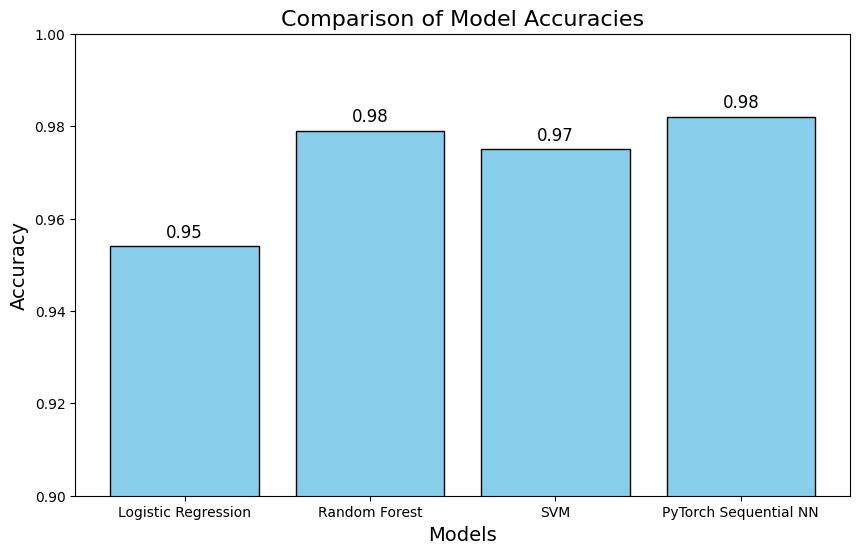

In [118]:
model_accuracies = {
    'Logistic Regression': 0.954,
    'Random Forest': 0.979,
    'SVM': 0.975,
    'PyTorch Sequential NN': 0.982
}

model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue', edgecolor='black')

plt.title('Comparison of Model Accuracies', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.9, 1.0)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.002, f"{acc:.2f}", ha='center', fontsize=12)

plt.show()